### Needed Libraries


In [ ]:
import sympy as sp
import numpy as np
from numpy import diag, array
from numpy.linalg import eig
import math
from sympy.physics.mechanics import *
from sympy.utilities.lambdify import lambdify
from matplotlib.pyplot import *
from scipy.linalg import solve_discrete_are as dare
from numpy import genfromtxt
from scipy.signal import cont2discrete
rcParams.update({'font.size': 20})

### Reading the optimal trajectory data.

In [ ]:
ang = genfromtxt('angle.csv', delimiter=',')
dist = genfromtxt('distance.csv', delimiter=',')
ang_vel = genfromtxt('angular_velocity.csv', delimiter=',')
vel = genfromtxt('velocity.csv', delimiter=',')
u_opt = genfromtxt('u_opt.csv', delimiter=',')

x_d = np.array([ang[:-1], ang_vel[:-1], dist[:-1], vel[:-1]])
u_opt = np.array(u_opt)

# System Dynamics Linearization

 A convinient way to do linearization is to linearize system dynamics nearby equilibrium point or desired trajectory:

\begin{equation}
\dot{\mathbf{x}}
= \mathbf{f}(\mathbf{x}_d,\mathbf{u}_d)+ 
\frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d} 
(\mathbf{x} - \mathbf{x}_d) + 
\frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}  
(\mathbf{u} - \mathbf{u}_d) 
\end{equation}

Introducing the tracking error $\tilde{\mathbf{x}}$ we may rewrite the equation above in linear form as follows:

\begin{equation}
\dot{\tilde{\mathbf{x}}} = \mathbf{A}\tilde{\mathbf{x}} + \mathbf{B}\tilde{\mathbf{u}}   
\end{equation}
where: $\tilde{\mathbf{x}}$ is tracking error, $\tilde{\mathbf{u}}$ is the new control input $\mathbf{A} = \frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$ - state evaluation matrix, $\mathbf{B} = \frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$

Thus linearization consist of two steps:


1.   Calculation of the system $\mathbf{f}$ Jacobians with respect to state $\mathbf{x}$ and control $\mathbf{u}$
2.   Evaluation of the resulting Jacobians in the desired point $\mathbf{x}_d, \mathbf{u}_d$


In [ ]:
I, m, M, L, g = sp.symbols(r'I m M L g')

s, c = sp.sin, sp.cos

x_sym = sp.symbols(r'\theta \dot{\theta} x \dot{x}')
u_sym = sp.symbols(r'u')

# Nonlinear cart-pole dynamics
def f_cp(x, u, parameters):
    I, m, M, L, g = parameters
    theta, dtheta, p, dp = x
    denom =  I*0 + M + m*(s(theta)**2) 
    ddp = (L*m*s(theta)*dtheta**2 + u + m*g*c(theta)*s(theta))/denom
    ddtheta = (-L*m*c(theta)*s(theta)*dtheta**2 - u*c(theta) -(M+m)*g*s(theta))/(L*denom)
    return dtheta, ddtheta, dp, ddp

f_sym = sp.Matrix(f_cp(x_sym, u_sym, (I, m, M, L, g )))
Jx_sym = f_sym.jacobian([x_sym])
Ju_sym = f_sym.jacobian([u_sym])
Jx_sym

Matrix([
[                                                                                                                                                                                                                                                                                               0,                                                                1, 0, 0],
[-2*m*(-L*\dot{\theta}**2*m*sin(\theta)*cos(\theta) - g*(M + m)*sin(\theta) - u*cos(\theta))*sin(\theta)*cos(\theta)/(L*(M + m*sin(\theta)**2)**2) + (L*\dot{\theta}**2*m*sin(\theta)**2 - L*\dot{\theta}**2*m*cos(\theta)**2 - g*(M + m)*cos(\theta) + u*sin(\theta))/(L*(M + m*sin(\theta)**2)), -2*\dot{\theta}*m*sin(\theta)*cos(\theta)/(M + m*sin(\theta)**2), 0, 0],
[                                                                                                                                                                                                                                                                      

### System Parameter and Simulation Parameters

In [ ]:
N = 200
T = 2
dT = T/N

m1 = 0.3
M1 = 1 
L1 = 0.5 
g1 = 9.81
I1 = 0.006 

C = np.array([[1, 0, 0 ,0]])
D = np.array([[0, 0]])

Q = np.diag([1,1,1,1])
R = np.diag([1])

Functions to Evaluate the Jacobians in N points of the desired trajectory

In [ ]:
A_fnc = lambdify([x_sym, u_sym, [I, m, M, L, g]], Jx_sym)
B_fnc = lambdify([x_sym, u_sym, [I, m, M, L, g]], Ju_sym)

Evaluating the Jacobians, Then Discretize the system dynamics $\mathbf{A}_{d}$ and $\mathbf{B}_{d}$


In [ ]:
A_n, B_n = [],[]

for k in range(N):
  A = A_fnc(x_d[:,k], u_opt[k], [I1, m1, M1, L1, g1])
  B = B_fnc(x_d[:,k], u_opt[k], [I1, m1, M1, L1, g1])

  # Discretize A and B
  A_d, B_d, C_d, D_d, _ = cont2discrete((A,B,C,D), dT)  
  A_n.append(A_d)
  B_n.append(B_d)

A function to compute the Discrete Time Variant LQR gain $\mathbf{K}_{LQR}$

A feedback controller whose equations are given below:

\begin{equation}
J_c=\sum \limits _{{k=0}}^{{\infty }}\left(\mathbf{x}_{k}^{T}\mathbf{Q}\mathbf{x}_{k}+\mathbf{u}_{k}^{T}\mathbf{R}\mathbf{u}_{k}\right) + \mathbf{x}_{N}^{T}\mathbf{H}\mathbf{x}_{N}
\end{equation}

The optimal control sequence minimizing the performance index is given by:

\begin{equation}
\mathbf{u}_{k}=-\mathbf{K}_{LQR} (\mathbf{x}_{k} - \mathbf{x}_{d_k}) + \mathbf{u}_{d_k}
\end{equation}
Where  $\mathbf{K}_{LQR}$ is time variant gain given by:

\begin{equation}
\mathbf{K}_{N-k}= (\mathbf{R}_{N-k}+ \mathbf{B}_{N-k}^{T}\mathbf{P}_{N-k+1}\mathbf{B}_{N-k}) \mathbf{B}_{N-k}^T \mathbf{P}_{N-k+1} \mathbf{A}_{N-k}
\end{equation}

P updates with difference Riccati equation (DRE):

\begin{equation}
\mathbf{P}_{N-k}= \mathbf{Q}_{N-k}+ \mathbf{K}_{N-k}^{T}\mathbf{R}_{N-k}\mathbf{K}_{N-k} + (\mathbf{A}_{N-k} - \mathbf{B}_{N-k} \mathbf{K}_{N-k})^T \mathbf{P}_{N-k+1} (\mathbf{A}_{N-k} - \mathbf{B}_{N-k} \mathbf{K}_{N-k})
\end{equation}


In [ ]:
def dlqr_ltv(A, B, H, Q, R):
    N = 200 
    n = 4
    P=H
    K=np.zeros((N,n))
    for i in range(1,N):
        # Compute the LQR gain
        gain = np.linalg.inv(R + B[N-i].T @ P @ B[N-i]) @ B[N-i].T @ P @ A[N-i]
        K[N - i, :] = gain
        # Update with difference Riccati equation
        P = Q + gain.T @ R @ gain + (A[N-i]- B[N-i] @ gain).T @ P @ (A[N-i]- B[N-i] @ gain)
    return K

In [ ]:
# Compute the gain K
K_vt = dlqr_ltv(A_n, B_n, 12.5*Q, 12.5*Q, 0.95*R)

Nonlinear Dynamics of the System

In [ ]:
def f(x,u,parameters):
  I, m, M, L, g = parameters
  theta, dtheta, p, dp = x
  denom =  I*0 + M + m*(1 - np.cos(theta)**2) 
  ddp = (L*m*np.sin(theta)*dtheta**2 + u + m*g*np.cos(theta)*np.sin(theta))/denom
  ddtheta = (-L*m*np.cos(theta)*np.sin(theta)*dtheta**2 - u*np.cos(theta) -(M+m)*g*np.sin(theta))/(L*denom)
  return np.array([dtheta, ddtheta, dp, ddp], dtype='double')

# Simulation using Time Variant LQR Controller
 
The optimal control sequence minimizing the performance index is given by:

\begin{equation}
\mathbf{u}_{k}=-\mathbf{K}_{LQR} (\mathbf{x}_{k} - \mathbf{x}_{d_k}) + \mathbf{u}_{d_k}
\end{equation}
Where  $\mathbf{K}_{LQR}$ is time variant gain given by the equation mentioned before.


In [ ]:
U = []
X = []
x = np.array([0, 0, 0, 0])

N2 = 1000
xd = np.zeros((4,N2))
ud = np.zeros(N2)
Kd = np.zeros((N2,4))

for k in range(N2):
  if k >= 200:
    xd[:,k] = x_d[:,-1]
    Kd[k] = [30.39605308,  6.20286864, -0.54225594, -1.49816905]
    u = -np.dot(Kd[k], x - xd[:,k])
    x = x + f(x, u, (I1, m1, M1, L1, g1))*dT
  if k < 200:
    xd[:,k] = x_d[:,k]
    ud[k] = u_opt[k] 
    Kd[k] = K_vt[k]
    u = -np.dot(Kd[k], x - xd[:,k]) + ud[k]
    x = x + f(x, u, (I1, m1, M1, L1, g1))*dT
  
  U.append(u)
  X.append(x)

X = np.array(X)
U = np.array(U)
theta, dtheta, p, dp = X[:,0], X[:,1], X[:,2], X[:,3] 

Plotting the Simulated Trajectory and Control results and Comparing them with the optimal ones.

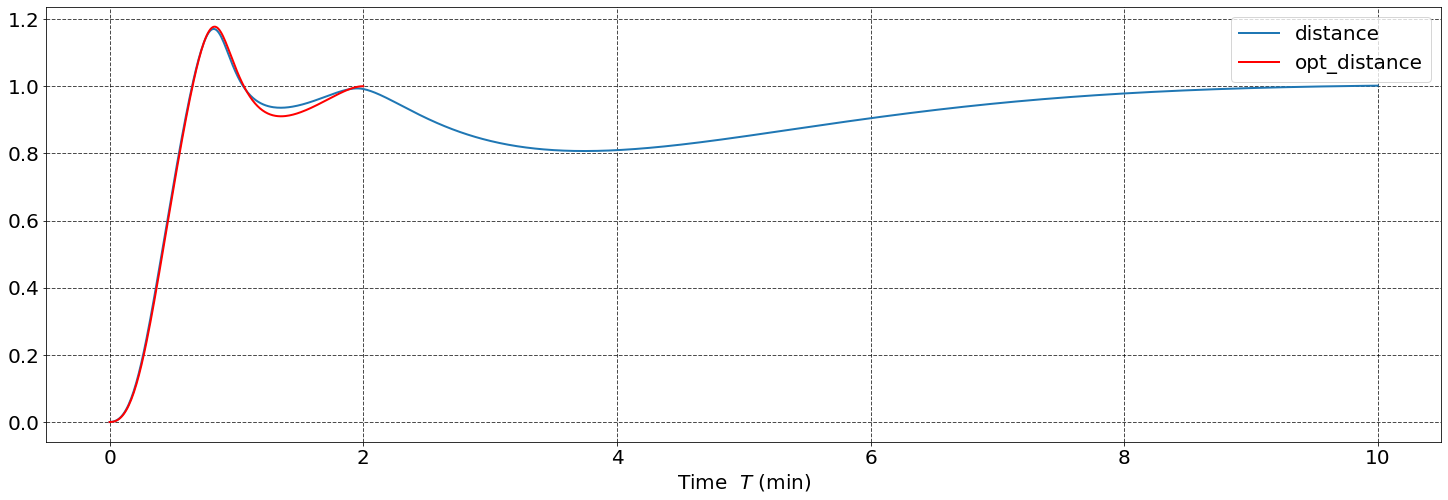

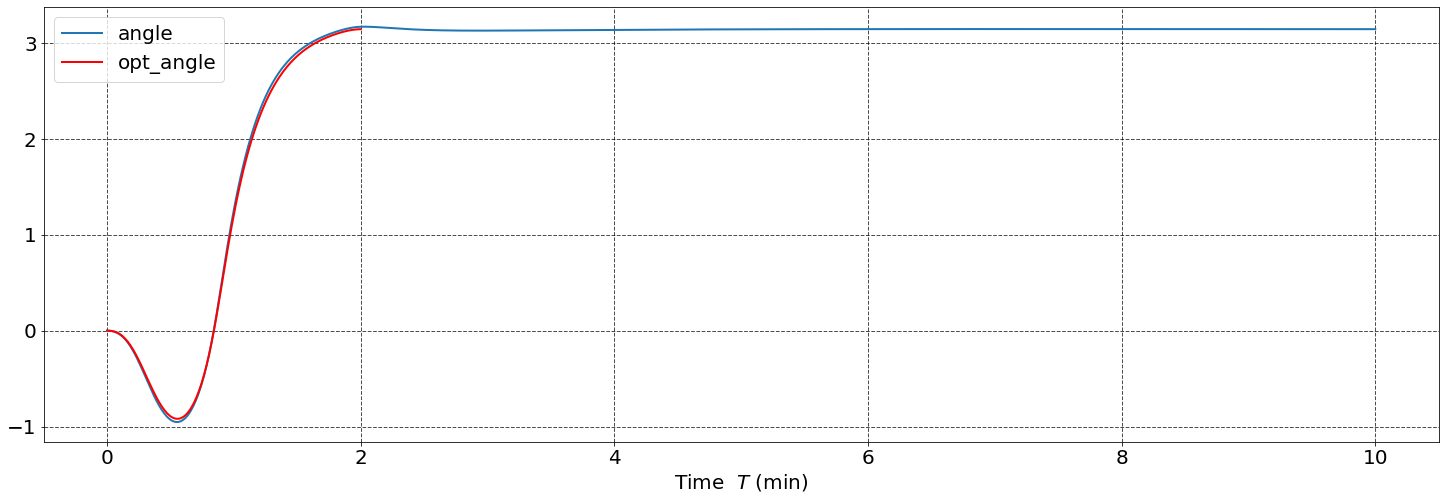

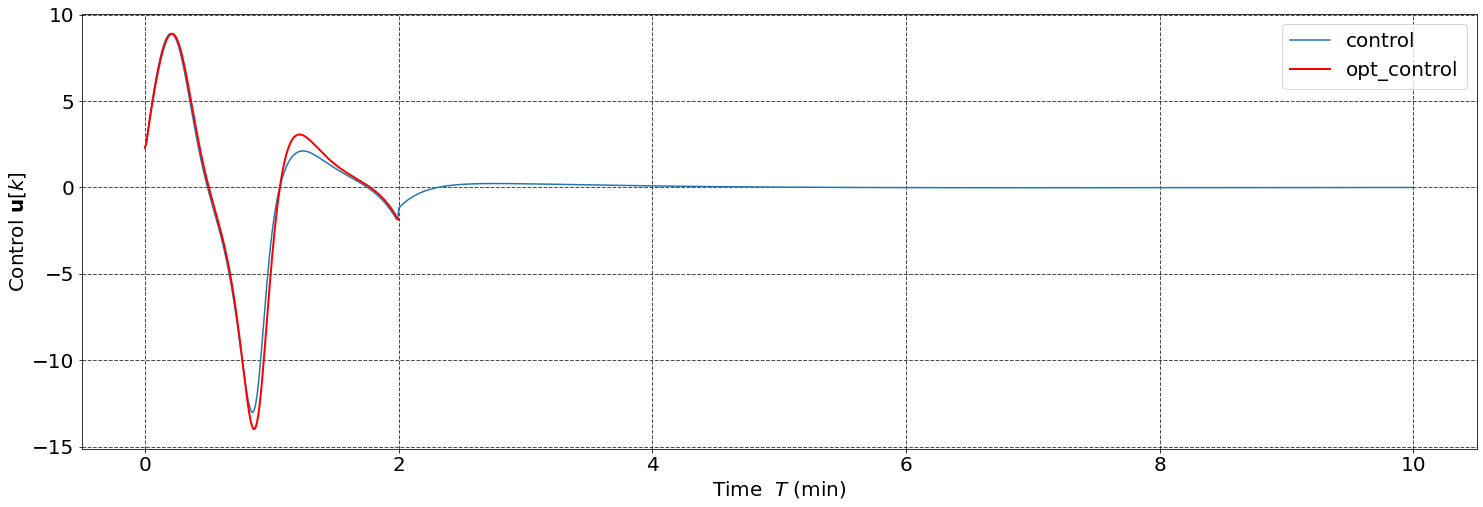

In [ ]:
t = np.linspace(0, T, N)
t2 = np.linspace(0, 10, N2)

figure(figsize=(25, 8))
plot(t2, p , linewidth=2.0, label='distance')
plot(t, dist[:-1],'r', linewidth=2.0, label='opt_distance')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel(r'Time  $T$ (min)')
legend()
show()

figure(figsize=(25, 8))
plot(t2, theta, linewidth=2.0, label='angle')
plot(t, ang[:-1],'r', linewidth=2.0, label='opt_angle')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel(r'Time  $T$ (min)')
legend()
show()

figure(figsize=(25, 8))
plot(t2,U, label='control')
plot(t, u_opt,'r', linewidth=2.0, label='opt_control')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylabel(r'Control $\mathbf{u}[k]$')
xlabel(r'Time  $T$ (min)')
legend()
show()